# Unsupervised Document Clustering with Cluster Topic Identification

In this notebook, we will show an example of the pipeline outlined in the associated paper Unsupervised Document Clustering with Cluster Topic Identification. The notebook has the following structure:

- Data preprocessing
- Building a Doc2Vec model
- Dimensionality reduction using t-distributed stochastic neighbourhood embedding (t-SNE)
- Unsupervised clusering using HDBSCAN
- Topic identification using singular value decomposition (SVD)

## Load modules 

In [1]:
%matplotlib inline

import string
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import hdbscan
import seaborn as sns
import re
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from gensim.models.deprecated.doc2vec import LabeledSentence

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
filepath = '/home/mike/doc_clustering/companies_house/data.csv'

data = pd.read_csv(filepath, usecols=["Industrial Sector Group", "Descriptions"], encoding="iso8859-1")

# The Doc2Vec model requires that both the document labels and strings are in a list format

docLabels = list(range(0,len(data)))
descriptions = data['Descriptions'].tolist()

In [63]:
# Data visualisation

for i in range(10):
    print('\033[1m' + "{0}. ".format(i) + descriptions[i] + '\n' + '\033[0m')

0. continued ownership development patent development specialist flooring solutions subsidiary undertaking abc uk

1. development specialist flooring solutions

2. cart ref ni continues pursue main objective provide superior trusted person centred support vulnerable adults living their own homes

3. schools purpose carry on day school girls

4. under maintenance houses common grounds forming heights no estate

5. provides housing development services

6. general shipping agents container ships car carriers throughout europe

7. chartering ownership bulk vessels

8. were theâownership one lng vessel ship management operations lng vessels

9. companys continued running retail pharmacies under trading name lindsay glamour



## Data preprocessing

Here we will preprocess the data to get rid of redundant information. 

In [4]:
# Strip punctuation from the strings - not needed in this application

translator = str.maketrans('', '', string.punctuation)

descriptions = [char.translate(translator) for char in descriptions]

# Some characters are retained using string.punctuation.
# Here we remove chars and punctuation not pulled out by string.punctuation and digits

replace = {"ﬁ": "fi", "ï¬": "fi", "ï¬": "fl", "â": "", "â": "", "â": "", "’": "", "‘": "", "”": "", "“": ""}
    
replace = dict((re.escape(k), v) for k, v in replace.items())
pattern = re.compile("|".join(replace.keys()))
    
for i in range(len(descriptions)):       
    descriptions[i] = re.sub(r'\d+', '', descriptions[i])
    descriptions[i] = pattern.sub(lambda m: replace[re.escape(m.group(0))], descriptions[i])

In [5]:
# We will also remove common words that add little information in this application - 
# for example 'Principal Activity'

StopWords = ["principal", "principle", "activity", "activities", "s", "company", "is", "that", "of", "a", 
"the", "and", "lp", "to", "was", "business", "review", "limited", "ltd", "ltd.", "group", "during", 
"year", "as", "to", "be", "company's", "sale", "an", "are", "in", "it", "into", "with", "have", 
"its", "for"]

for i in range(0,len(descriptions)):
    descriptions[i] = ' '.join([word for word in descriptions[i].split() if word not in StopWords])

## Building a Doc2Vec model

Here we build a Doc2Vec model. We create a model using a 500-dimensional vector space with a fixed learning rate. 

The documentation can be found here: 

- https://radimrehurek.com/gensim/models/doc2vec.html

In [6]:
LabeledSentence = gensim.models.deprecated.doc2vec.LabeledSentence

# Doc2Vec algorithm, embedding into a 500-dimensional vector space

class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
       self.labels_list = labels_list
       self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc.split(),tags=[self.labels_list[idx]])

it = LabeledLineSentence(descriptions, docLabels)

model = gensim.models.Doc2Vec(vector_size=500, window=10, min_count=2, workers=4,alpha=0.025, min_alpha=0.001)

model.build_vocab(it)

for epoch in range(20):
    model.train(it, total_examples=len(data), epochs = 50)

In [10]:
# Save model 

# model.save('/home/mike/doc_clustering/companies_house/doc2vec.model')

### Inferring new vectors

We can also infer new vectors into the model and return the nearest vectors under the cosine distance to the inferred vector. This is neat; if the model is producing meaningful embeddings one would expect, the the nearest vectors to the inferred vector should be semantically similar! This could be useful if you are interested in certain topics too as we can use the model as a loose lookup table. 

In [49]:
model = gensim.models.Doc2Vec.load('/home/mike/doc_clustering/companies_house/doc2vec.model')

tokens = "elderly disabled care".split()

topic = model.infer_vector(tokens, alpha=0.025, min_alpha=0.001, steps=100000)

similar_documents = model.docvecs.most_similar([topic], topn=5)

# print similar_documents

for i in range(5):
    print('\033[1m' + '{0}. '.format(i) + data['Descriptions'][similar_documents[i][0]] + '\n' + '\033[0m')

0. principal activity the principal activity of the company is that of providing long term care for the elderly and inï¬rm, and specialised care for the young physically disabled.

1. principal activities the principal activity of the company is the provision of care services including personal care for frail elderly, nursing care, dementia care, support and care for physically disabled adults, palliative care and huntingtonâs care.

2. principal activities the principal activity of the company during the year was residential care for the elderly and disabled.

3. principal activity the principal activity fjord (care) lp is the provision of care services.

4. principal activities the principal activity of the company during the year was the provision of residential care services for the elderly and disabled.



## Dimensionality reduction using t-SNE

With this model, we have embedded each document describing a business into a 500-dimensional vector. We can consider the Doc2Vec model to be a feature transformation from a set of strings to a feature/vector space. The idea is that this is a useful transformation as it will hopefully(!) position similar documents together. 

Now that we have transformed our data strings into numerical features we can do start doing more standard data analysis techniques. First we will visualise our data using dimensionality reduction to two dimensions using t-SNE.

The documentation is found here: 

- http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- https://lvdmaaten.github.io/tsne/

In [7]:
# It is worth noting that t-SNE doesn't support huge datasets (as far as I know..), so we will take 
# a random sample of our vector space of 30,000 examples. 

# We also add information from the SIC grouping to help grouping

groups = np.asarray(data['Industrial Sector Group'].tolist()) / float(21)
groups = np.reshape(groups, (len(groups), 1))

rand = random.sample(range(0,len(data)), 15000)

docvecs = np.concatenate([groups[rand], model.docvecs.doctag_syn0[rand]], axis=1)

In [8]:
docvecs.shape

(15000, 501)

In [9]:
# use t-SNE for dimensionality reduction with a cosine similarity measure & plot

tsne = manifold.TSNE(n_components=2, init='random', metric='cosine', random_state=None, method='barnes_hut')

tsne_model = tsne.fit_transform(docvecs)

<function matplotlib.pyplot.show>

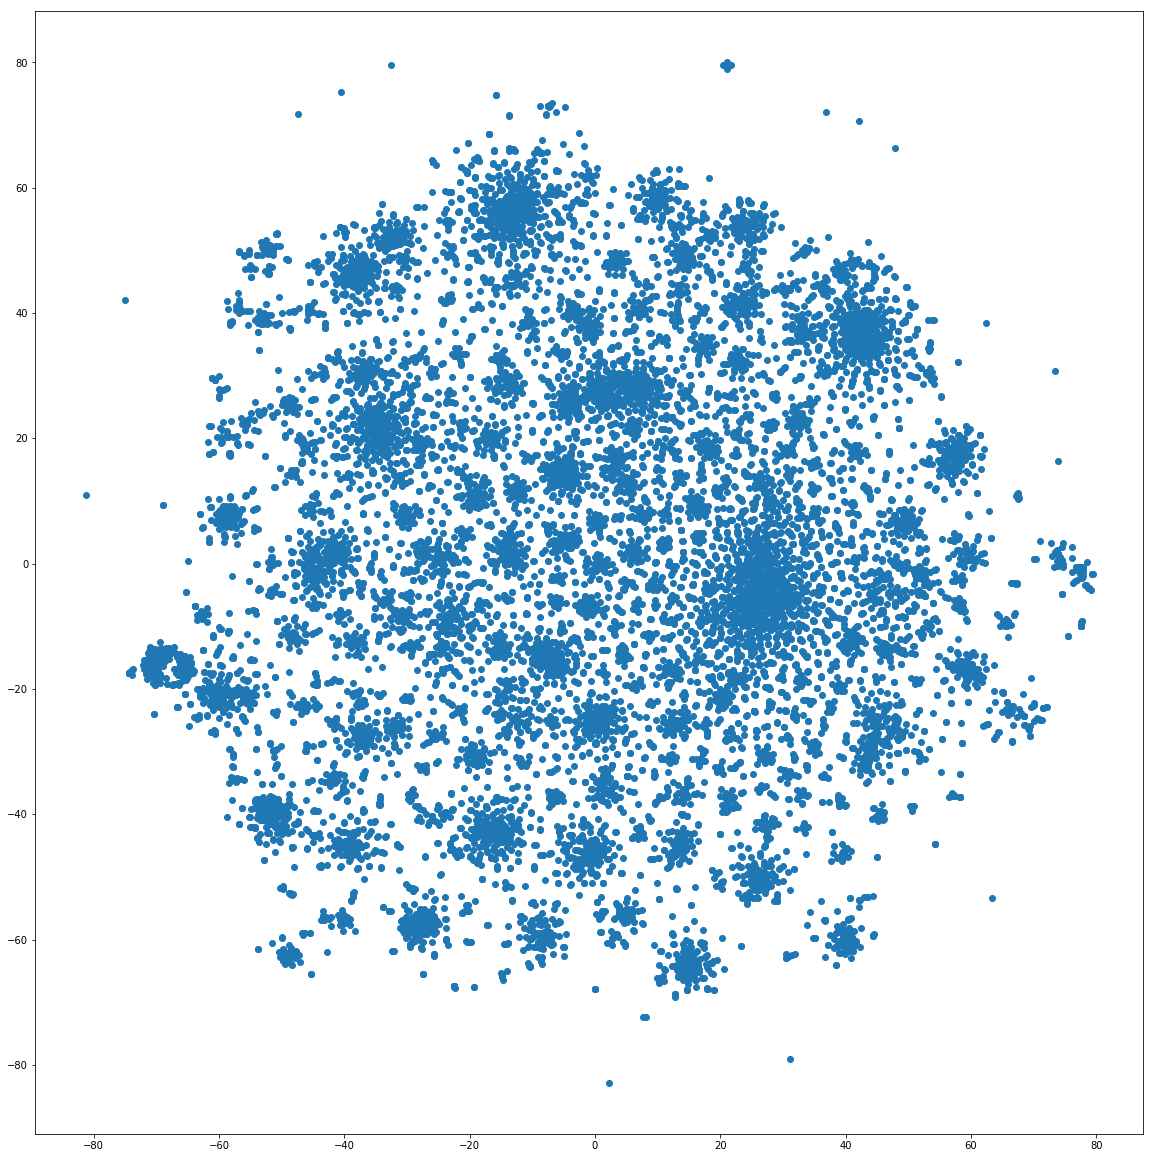

In [10]:
# Plot the 2D space 

plt.subplots_adjust(bottom = 0.1)
plt.scatter(tsne_model[:, 0], tsne_model[:, 1], marker = 'o')

plt.gcf().set_size_inches(20,20)
plt.gca().set_aspect('equal')

plt.show

## HDBSCAN for hierarchical clustering 

Here we use HDBSCAN to cluster points in the 2D-feature space created from t-SNE. HDBSCAN clusters by considering the density of points around an area - ignoring sparse points - rather than something like k-means which is based off of proximity to a centroid point. 

We can also tune the model such that it discovers smaller clusters which can be useful in this application of finding more niche business areas. 

The documentation is found here: 

- http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

2145


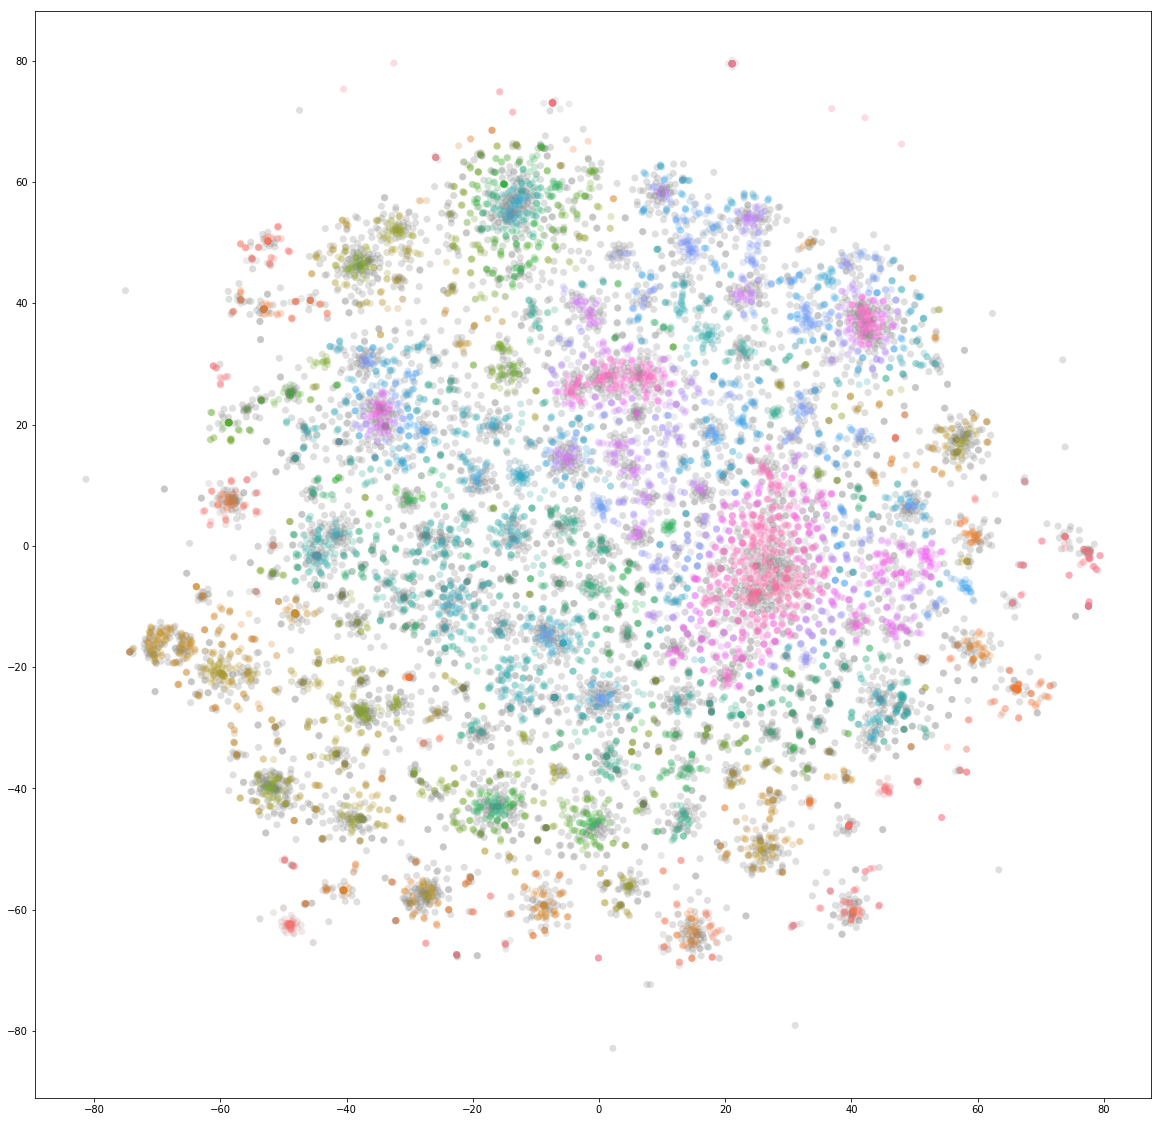

In [15]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2).fit(tsne_model)

color_palette = sns.color_palette('husl', 2200)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(*tsne_model.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.gcf().set_size_inches(20,20)

# find number of clusters found 

print(clusterer.labels_.max())

## Visualise clusters

We can pick out some members of clusters and see the relationships between the members. 

In [41]:
def clusters(cluster_no):
    newlist = []
    
    for i in range(15000):
        if clusterer.labels_[i] == cluster_no:
            newlist.append(rand[i])
            
    for i in range(len(newlist)):
        # print(data['Industrial Sector Group'][newlist[i]])
        print(data['Descriptions'][newlist[i]] + '\n')
        
    return len(newlist)



In [169]:
a = random.randint(0,2145)
b = random.randint(0,2145)
c = random.randint(0,2145)

print('\033[1m' +  'Cluster {0}: \n'.format(a) + '\033[0m')
clusters(a)
print('\n')
print('\033[1m' + 'Cluster {0}: \n'.format(b) + '\033[0m')
clusters(b)

print('\033[1m' + 'Cluster {0}: \n'.format(c) + '\033[0m')
clusters(c)

Cluster 597: 

principal activities the principal activity of the company was to act as a holding company.

principal activity the principal activity of the company is to act as a holding company.

principal activities the principal activity of the company is to act as a holding company.

principal activity the principal activity of the company is to act as a holding company.

principal activity the principal activity of the company is to act as a holding company.

principal activities the principal activity of the company is to act as a holding company.



Cluster 47: 

principal activity the principal activity of the company is the renting of an investment property.

principal activities the principal activity of the company is that of renting a property to a group company.

principal activities the principal activity of the company is the renting of property in spain.

Cluster 147: 

principal activity the principal activity of the lp is that of a holding entity of a legal services 

5

## Using SVD for topic identification 

The idea here is to take the singular value decomposition of the document vectors within a cluster. If we take the vector associated with the biggest singular value (which is the best low rank approximation of the matrix) - we can infer that vector back into the original model and choose the closest vector as the document that best describes the cluster.

If the model is trained well and the feature space created by Doc2Vec is representative of the data then this approach one way to automate extracting a topic. Other ideas might include finding the average vector in a cluster and identifying topic by the nearest vector to the mean. We could also try something like Latent Dirichlet Allocation on the whole corpus of a cluster to identify a topic. In each case it will be faster than a manual search. 

In [140]:
def svd_test(cluster_no):
    indices = []
    
    for i in range(15000):
        if clusterer.labels_[i] == cluster_no:
            indices.append(i)
    
    return docvecs[indices]
    

# find a low rank approximation of the document matrix (rank 1 in this case) to infer back into the model

def principal_vector(svd_matrix):
    svd = TruncatedSVD(n_components=1, n_iter=10, random_state=42)
    svd.fit(svd_matrix)
    
    return svd.components_


# return the nearest document vector(s) closest to the rank 1 approximation of the cluster's document matrix
   
def cluster_topic(vector):
    p = vector[:,1:]
    p = np.reshape(p, (500,)).astype(np.float32)
    sim_docs = model.docvecs.most_similar([p], topn=1)

    return print('\033[1m' + 'CLUSTER TOPIC: ' + '\033[0m' + data['Descriptions'][sim_docs[0][0]])


# return a cluster description

def cluster_description(cluster_number):
    svd_matrix = svd_test(cluster_number)
    vector = principal_vector(svd_matrix)
    
    return cluster_topic(vector)

## Examples

In [152]:
cluster_no = 3

cluster_description(cluster_no) 
print('\n')
clusters(cluster_no)




CLUSTER TOPIC: principal activities the principal activity of the company was that oaf corporate member at loyd's.


principal activities the principal activity of the company was that oaf corporate member at loyd's.

principal activities the principal activity of the company was that oaf corporate member at loyd's.

principal activities the principal activity of the company was that oaf corporate member at loyd's.



3

In [153]:
cluster_no = 4

cluster_description(cluster_no) 
print('\n')
clusters(cluster_no)

CLUSTER TOPIC: principal activity and review of the business the principal activity of the company continues to be the provision of a comprehensive service to clients covering advertising, marketing and allied services.


principal activity and review of the business the principal activity of the company continues to be the provision of a comprehensive service to clients covering advertising, marketing and allied services.

principal activity and review of the business the principal activity of the company continues to be the provision of a comprehensive service to clients covering advertising, marketing and allied services.

principal activity and review of the business the principal activity of the company continues to be the provision oaf comprehensive service to clients covering advertising, marketing and allied services.



3

In [154]:
cluster_no = 5

cluster_description(cluster_no) 
print('\n')
clusters(cluster_no)

CLUSTER TOPIC: principal activity the principal activity of the lp in the yearâunder review is to act as general partner (âthe general partnerâ) to general partner no.


principal activity of mercia (general partner) limited (âthe companyâ) during the period was to act as a general partner of mercia investment plan lp and of mercia (special limited partner) lp.

principal activities r' unworthy second partner limited (the âcompanyâ) is a member of unworthy clinical co develop met general partner lp, unworthy general partner v1 lp, unworthy general partner v lp, unworthy general partner 1v lp, unworthy general partner 111 lp (âthe lapsâ).

principal activity the principal activity of the lp in the yearâunder review is to act as general partner (âthe general partnerâ) to general partner no.

principal activity the company is the corporate member of aquitaine general partner v lp and the general partner of aquitaine general partner (carry & co-invest) v lp.



4

In [156]:
cluster_no = 6

cluster_description(cluster_no) 
print('\n')
clusters(cluster_no)

CLUSTER TOPIC: principal activities the principal activity of the partnership is that otâa limited liability underwriting member of lloydâs.


principal activities the principal activity of the partnership is that otâa limited liability underwriting member of lloydâs.

principal activities the principal activity of the partnership is that otâa limited liability underwriting member of lloydâs.

principal activities the principal activity of the partnership is that otâa limited liability underwriting member of lloydâs.



3

In [166]:
cluster_no = 1001

cluster_description(cluster_no) 
print('\n')
clusters(cluster_no)

CLUSTER TOPIC: principal activities, business review and future developments the company is an inter group ï¬nance company and will continue as an inter group ï¬nance company for the foreseeable future.


principal activities ba finance 2 limited was incorporated on 14 july 2015 and is an investment holding company within the walgreen's boots alliance, inc.

principal activities halcyon finance limited (the "company") operates as a ï¬nance and investment company within the kingï¬sher lc group (the "group").

principal activity the principal activity of the company is to act as a finance company.

principal activity the company is a group ï¬nance company it dd not trade during the current or prole year and, therefore.

principal activities, business review and future developments the company is an inter group ï¬nance company and will continue as an inter group ï¬nance company for the foreseeable future.

principal activity the principal activity of the company is to facilitate th

7